***Students***: *Claire Acciari and Caroline Moreau*

---
---

# NLP project: Machine Translation on the Europarl corpus

---

## Data preparation

In this first section, we prepared the dataset for the analysis.

We performed the following steps:

- Import of the data and pre-processing

- Tokenisation of the text

- Embedding of the tokens with a Word2Vec model

- Building the dataloaders

### Library imports

In [2]:
%matplotlib inline

In [3]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     / 25.9 MB 782 kB/s
     |████████████████████████████████| 10.9 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 
     |████████████████████████████████| 102 kB 9.4 MB/s 
     |████████████████████████████████| 690 kB 43.2 MB/s 
     |████████████████████████████████| 4.7 MB 39.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 812 kB 42.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261287 sha256=779be1e50f2fe3b164508487fba053efa0499d940acdec461c6e1db975ad42e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-9djyzlgi/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=c68e4e534e08e0a597a4083ed1a29d6c6ed5a971fc57e362ff0215bcaa5c54ab
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d

In [4]:
!pip install datasets sacrebleu transformers torchinfo

     |████████████████████████████████| 325 kB 4.5 MB/s 
     |████████████████████████████████| 90 kB 4.3 MB/s 
     |████████████████████████████████| 4.0 MB 6.0 MB/s 
     |████████████████████████████████| 136 kB 33.5 MB/s 
     |████████████████████████████████| 1.1 MB 32.5 MB/s 
     |████████████████████████████████| 77 kB 3.7 MB/s 
     |████████████████████████████████| 212 kB 37.2 MB/s 
     |████████████████████████████████| 138 kB 35.7 MB/s 
     |████████████████████████████████| 895 kB 33.6 MB/s 
     |████████████████████████████████| 6.6 MB 42.7 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 37.0 MB/s 
     |████████████████████████████████| 271 kB 38.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [5]:
import nltk
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer, ToktokTokenizer
from sacrebleu.metrics import BLEU

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datasets
from datasets import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from multiprocessing import cpu_count
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from termcolor import colored
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, get_scheduler

### Dataset import

We are going to work on the European Parliament Parallel Corpus: [Europarl](https://www.statml.org/europarl/).

This corpus gathers transcriptions of the Europen parliament proceedings in 21 European languages.The resulting text has been pre-processed and sentence aligned to be used in Machine Translation tasks.

In this work, we chose to focus on the French-English texts. Our goal was to build a translator from French to English

In [6]:
!wget https://statmt.org/europarl/v7/fr-en.tgz

--2022-04-24 16:38:55--  https://statmt.org/europarl/v7/fr-en.tgz
Resolving statmt.org (statmt.org)... 129.215.197.184
Connecting to statmt.org (statmt.org)|129.215.197.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘fr-en.tgz’

fr-en.tgz           100%[===================>] 193.33M  4.05MB/s    in 48s     

2022-04-24 16:39:43 (4.02 MB/s) - ‘fr-en.tgz’ saved [202718517/202718517]



In [7]:
!tar zxvf fr-en.tgz

europarl-v7.fr-en.en
europarl-v7.fr-en.fr


In [8]:
with open('europarl-v7.fr-en.fr') as f:
  lines_fr = f.readlines()

for line in lines_fr[0:10]:
  print(line)

Reprise de la session

Je déclare reprise la session du Parlement européen qui avait été interrompue le vendredi 17 décembre dernier et je vous renouvelle tous mes vux en espérant que vous avez passé de bonnes vacances.

Comme vous avez pu le constater, le grand "bogue de l'an 2000" ne s'est pas produit. En revanche, les citoyens d'un certain nombre de nos pays ont été victimes de catastrophes naturelles qui ont vraiment été terribles.

Vous avez souhaité un débat à ce sujet dans les prochains jours, au cours de cette période de session.

En attendant, je souhaiterais, comme un certain nombre de collègues me l'ont demandé, que nous observions une minute de silence pour toutes les victimes, des tempêtes notamment, dans les différents pays de l'Union européenne qui ont été touchés.

Je vous invite à vous lever pour cette minute de silence.

(Le Parlement, debout, observe une minute de silence)

Madame la Présidente, c'est une motion de procédure.

Vous avez probablement appris par la pre

We here choose to limit our analysis to 20.000 sentences mostly for computation purposes. All our algorithms are quite costly computation wise, limiting us greatly in our work. Considering more sentences would greatly benefit the accuracy of our models.

In [9]:
with open('europarl-v7.fr-en.en') as f:
  lines_en = f.readlines()

#Truncate lines_fr and lines_en for RAM savings
lines_fr = lines_fr[0:20000]
lines_en = lines_en[0:20000]

In [10]:
len(lines_fr)

20000

### Tokenisation

In this section, we tokenized both of our texts.

To do so, we used the TweetTokenizer from the nltk package and ran a multi-word expression detector. We then constructed the resulting vocabulary and provided a representation of word occurences in our texts.

In [11]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# We observe identical behaviours for the three tokenizers considered here
tok_tweet = TweetTokenizer()
tok_tree = TreebankWordTokenizer()
tok_tok = ToktokTokenizer()
entry = lines_fr[2]
tokens = tok_tweet.tokenize(entry.lower().strip())
print(tokens)
tokens = tok_tree.tokenize(entry.lower().strip())
print(tokens)
tokens = tok_tok.tokenize(entry.lower().strip())
print(tokens)

['comme', 'vous', 'avez', 'pu', 'le', 'constater', ',', 'le', 'grand', '"', 'bogue', 'de', "l'an", '2000', '"', 'ne', "s'est", 'pas', 'produit', '.', 'en', 'revanche', ',', 'les', 'citoyens', "d'un", 'certain', 'nombre', 'de', 'nos', 'pays', 'ont', 'été', 'victimes', 'de', 'catastrophes', 'naturelles', 'qui', 'ont', 'vraiment', 'été', 'terribles', '.']
['comme', 'vous', 'avez', 'pu', 'le', 'constater', ',', 'le', 'grand', '``', 'bogue', 'de', "l'an", '2000', "''", 'ne', "s'est", 'pas', 'produit.', 'en', 'revanche', ',', 'les', 'citoyens', "d'un", 'certain', 'nombre', 'de', 'nos', 'pays', 'ont', 'été', 'victimes', 'de', 'catastrophes', 'naturelles', 'qui', 'ont', 'vraiment', 'été', 'terribles', '.']
['comme', 'vous', 'avez', 'pu', 'le', 'constater', ',', 'le', 'grand', '"', 'bogue', 'de', 'l', "'", 'an', '2000', '"', 'ne', 's', "'", 'est', 'pas', 'produit.', 'en', 'revanche', ',', 'les', 'citoyens', 'd', "'", 'un', 'certain', 'nombre', 'de', 'nos', 'pays', 'ont', 'été', 'victimes', 'de'

In [12]:
# Tokenizing all of our sentences
def tokenizer(lines):
  """
  Sentence tokenizer using the TweetTokenizer from the nltk package
  """
  tokenized_entries = []
  for entry in tqdm(lines):
    tokens = tok_tweet.tokenize(entry.lower().strip())
    tokenized_entries.append(tokens)
  return tokenized_entries

lines_fr = tokenizer(lines_fr)
lines_en = tokenizer(lines_en)
print(len(lines_en))

100%|██████████| 20000/20000 [00:01<00:00, 13839.00it/s]

20000


In [13]:
lines_en[0]

['resumption', 'of', 'the', 'session']

In [14]:
# Detecting our multi-word expression and choosing the right threshold
def show_phrases(tokenized_sentences, threshold): 
  """
  Displays the first 20 multi-word expressions found in the corpus
  """
  phrases = Phrases(tokenized_sentences, threshold=threshold).export_phrases(tokenized_sentences)
  for i in range(20):
    phrase = next(iter(phrases))
    print("Phrase found: {0} - Associated score: {1}".format(phrase[0], phrase[1]))

In [15]:
# Multi-word expressions in the English text
show_phrases(lines_en, 200)

Phrase found: b'once again' - Associated score: 319.42261717521234
Phrase found: b'natural disasters' - Associated score: 344.0352112676056
Phrase found: b'public prosecutor' - Associated score: 268.3398449612403
Phrase found: b'mrs schroedter' - Associated score: 282.1698113207547
Phrase found: b'de palacio' - Associated score: 598.1999999999999
Phrase found: b'de palacio' - Associated score: 598.1999999999999
Phrase found: b'next item' - Associated score: 459.13661685383323
Phrase found: b'strategic objectives' - Associated score: 213.8193286776301
Phrase found: b'five years' - Associated score: 237.74615384615385
Phrase found: b'five years' - Associated score: 237.74615384615385
Phrase found: b'de palacio' - Associated score: 598.1999999999999
Phrase found: b'five years' - Associated score: 237.74615384615385
Phrase found: b'five years' - Associated score: 237.74615384615385
Phrase found: b'five years' - Associated score: 237.74615384615385
Phrase found: b'strategic objectives' - As

In [16]:
# Multi-word expressions in the French text
show_phrases(lines_fr, 200)

Phrase found: b"l'an 2000" - Associated score: 655.6381205673758
Phrase found: b'certain nombre' - Associated score: 338.9279126808928
Phrase found: b'catastrophes naturelles' - Associated score: 1112.12
Phrase found: b'certain nombre' - Associated score: 338.9279126808928
Phrase found: b'minist\xc3\xa8re public' - Associated score: 226.83100233100234
Phrase found: b"l'ann\xc3\xa9e derni\xc3\xa8re" - Associated score: 549.8225176568342
Phrase found: b'cher coll\xc3\xa8gue' - Associated score: 303.0805339265851
Phrase found: b'd\xc3\xa8s lors' - Associated score: 305.1261440677966
Phrase found: b'\xc3\xa9tant donn\xc3\xa9' - Associated score: 653.0906040268457
Phrase found: b'jour appelle' - Associated score: 321.6018656716418
Phrase found: b'groupe socialiste' - Associated score: 209.29636892712549
Phrase found: b'objectifs strat\xc3\xa9giques' - Associated score: 415.34969512195124
Phrase found: b'cinq ans' - Associated score: 297.7156905594406
Phrase found: b'cinq prochaines' - Assoc

In [17]:
def multi_word_detection(lines):
  """
  Integrates the multi-word expressions as tokens in the corpus
  """
  phrases = Phrases(lines, threshold=200)
  phraser = Phraser(phrases)
  for i in tqdm(range(len(lines))):
    lines[i] = phraser[lines[i]]
  return lines, phraser

lines_fr, phraser_fr = multi_word_detection(lines_fr)
lines_en, phraser_en = multi_word_detection(lines_en)

100%|██████████| 20000/20000 [00:01<00:00, 11041.56it/s]


In [18]:
# The phraser model is now able to detect multi-word expressions in tokenized texts
phraser_en[["simple", "test", ":", "natural", "disasters"]]

['simple', 'test', ':', 'natural_disasters']

In [19]:
# We now construct our vocabulary
VOC = {'English': {'stoi': {}, 'counts': {}, 'nbwords': 0}, 'French': {'stoi': {}, 'counts': {}, 'nbwords': 0}}
LANGS = ['English', 'French']

def parse_entry(entry, lang):
  """
  Updates a pre-existing vocabulary with words found and their number of occurence in the corpus
  """
  for t in entry:
    if t not in VOC[lang]['stoi']: 
      VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
      VOC[lang]['counts'][t] = 1
      VOC[lang]['nbwords'] += 1
    else:
      VOC[lang]['counts'][t] = VOC[lang]['counts'][t] + 1

# Now we add the special symbols
for lang in LANGS:
  for t in special_symbols: 
    VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
    VOC[lang]['counts'][t] = 1
    VOC[lang]['nbwords'] += 1

In [20]:
for entry in tqdm(lines_fr): 
  parse_entry(entry, 'French')
  
for entry in tqdm(lines_en): 
  parse_entry(entry, 'English')

for lang in LANGS:
  VOC[lang]['itos'] = { v:k for k,v in VOC[lang]['stoi'].items()}

100%|██████████| 20000/20000 [00:00<00:00, 60551.43it/s]


In [21]:
print('Number of tokens in the French corpus: ', VOC['French']['nbwords'], "\n" 'Number of tokens in the English corpus:', VOC['English']['nbwords'])

Number of tokens in the French corpus:  23051 
Number of tokens in the English corpus: 15620


In [22]:
%matplotlib inline

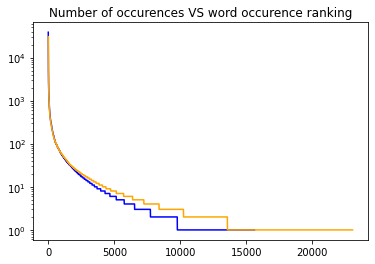

In [23]:
# Plotting the number of occurences of each token: Zip's law is verified
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(sorted(VOC['English']['counts'].values(), reverse=True), color='blue')
line2, = ax.plot(sorted(VOC['French']['counts'].values(), reverse=True), color='orange')

ax.set_yscale('log')
ax.set_title("Number of occurences VS word occurence ranking")

plt.show()

We observe that some word are greatly over-represented in both of our corpora. When training our model, we will have to take that into account when computing the loss by introducing weights penalising less frequent words more than frequent ones.

### Embedding with a Word2Vec model

After tokenizing our text, we were able to build an embedding. We used a Word2Vec model to contruct our word embedding. The resulting vectors will be stored for later use in our models.

In [ ]:
cpu = cpu_count()
model_en = Word2Vec(lines_en, size=100, window=5, min_count=3, workers=cpu)
model_en.train(lines_en, total_examples=len(lines_en), epochs=10)
wv_en = model_en.wv

model_fr = Word2Vec(lines_fr, size=100, window=5, min_count=3, workers=cpu)
model_fr.train(lines_fr, total_examples=len(lines_fr), epochs=10)
wv_fr = model_fr.wv

In [ ]:
## wv_en_vectors is to be used inside the embedding layer in the model
## wv_en_index2work is to be used during the numericalisation of the inputs
wv_en_vectors = wv_en.vectors

# We build the word to token_id dictionnary
wv_en_word2index = {}
for i in range(len(wv_en.index2word)):
  wv_en_word2index[wv_en.index2word[i]]=i
n=wv_en_vectors.shape[0]
# Adding special characters
wv_en_word2index['<sos>'] = n
wv_en_word2index['<eos>'] = n+1
wv_en_word2index['<unk>'] = n+2

# Adding the special characters embeddings
wv_en_vectors = np.concatenate((wv_en_vectors, np.zeros((3,100))), axis=0)

In [ ]:
wv_fr_vectors = wv_fr.vectors

# We build the word to token_id dictionnary
wv_fr_word2index = {}
for i in range(len(wv_fr.index2word)):
  wv_fr_word2index[wv_fr.index2word[i]]=i
n=wv_fr_vectors.shape[0]
# Adding special characters
wv_fr_word2index['<sos>'] = n
wv_fr_word2index['<eos>'] = n+1
wv_fr_word2index['<unk>'] = n+2

# Adding the special characters embeddings
wv_fr_vectors = np.concatenate((wv_fr_vectors, np.zeros((3,100))), axis=0)

In [ ]:
print("There is {0} tokens after the Word2Vec model training on the English corpus. \nThere is {1} tokens after the Word2Vec model training on the French corpus.".format(wv_en_vectors.shape[0], wv_fr_vectors.shape[0]))

There is 7736 tokens after the Word2Vec model training on the English corpus. 
There is 10241 tokens after the Word2Vec model training on the French corpus.


In [ ]:
"session" in wv_en_word2index

True

In [ ]:
# We now build the resulting vocabulary, along with the word counts
NEW_VOC = {'English': {'stoi': wv_en_word2index,
                       'counts': {w:0 for w in wv_en_word2index},
                       'nbwords': len(wv_en_word2index)},
           'French': {'stoi': wv_fr_word2index,
                      'counts': {w: 0 for w in wv_fr_word2index},
                      'nbwords': len(wv_fr_word2index)}}

def parse_W2V_entry(entry, lang):
  for t in entry:
    if t not in NEW_VOC[lang]['stoi']:
      NEW_VOC[lang]['counts']['<unk>']+=1
    else:
      NEW_VOC[lang]['counts'][t]+=1

for entry in tqdm(lines_fr): 
  parse_W2V_entry(entry, 'French')
  
for entry in tqdm(lines_en): 
  parse_W2V_entry(entry, 'English')

for lang in LANGS:
  NEW_VOC[lang]['itos'] = { v:k for k,v in NEW_VOC[lang]['stoi'].items()}

100%|██████████| 20000/20000 [00:00<00:00, 107181.56it/s]


In [ ]:
print(NEW_VOC['English']['counts']['the'])
print(np.sum([NEW_VOC['English']['counts'][w] for w in NEW_VOC['English']['counts']]))

38697
559540


### Building the dataset

After having prepared our text, we store it in a dataframe.

In [24]:
# We start by building a dataframe with the data at hand
EuroparlEnFr_df = pd.DataFrame({"English": lines_en, "French": lines_fr})
EuroparlEnFr_df.head()

,English,French
0,"[resumption, of, the, session]","[reprise, de, la, session]"
1,"[i, declare, resumed, the, session, of, the, e...","[je, déclare, reprise, la, session, du, parlem..."
2,"[although, ,, as, you, will, have, seen, ,, th...","[comme, vous, avez, pu, le, constater, ,, le, ..."
3,"[you, have, requested, a, debate, on, this, su...","[vous, avez, souhaité, un, débat, à, ce, sujet..."
4,"[in, the, meantime, ,, i, should, like, to, ob...","[en, attendant, ,, je, souhaiterais, ,, comme,..."


In [25]:
# We compute the length of each sentence
EuroparlEnFr_df["En_length_tok"] = EuroparlEnFr_df.English.apply(len)
EuroparlEnFr_df["Fr_length_tok"] = EuroparlEnFr_df.French.apply(len)

In [26]:
EuroparlEnFr_df.head()

,English,French,En_length_tok,Fr_length_tok
0,"[resumption, of, the, session]","[reprise, de, la, session]",4,4
1,"[i, declare, resumed, the, session, of, the, e...","[je, déclare, reprise, la, session, du, parlem...",39,34
2,"[although, ,, as, you, will, have, seen, ,, th...","[comme, vous, avez, pu, le, constater, ,, le, ...",36,40
3,"[you, have, requested, a, debate, on, this, su...","[vous, avez, souhaité, un, débat, à, ce, sujet...",21,21
4,"[in, the, meantime, ,, i, should, like, to, ob...","[en, attendant, ,, je, souhaiterais, ,, comme,...",47,43


In [ ]:
#EuroparlEnFr_df = EuroparlEnFr_df[EuroparlEnFr_df['Fr_length_tok']<=30]
#len(EuroparlEnFr_df)

In [27]:
# The maximum number of tokens in a sentence of our corpus
maxlen = max(np.max(EuroparlEnFr_df['En_length_tok']), np.max(EuroparlEnFr_df['Fr_length_tok'])) + 2
print(maxlen)

171


In [ ]:
# WARNING: very long to run when there is a lot of sentences
Europarl_profile = EuroparlEnFr_df.copy()
Europarl_profile["English"] = Europarl_profile["English"].apply(lambda x: ' '.join(x))
Europarl_profile["French"] = Europarl_profile["French"].apply(lambda x: ' '.join(x))
profile = ProfileReport(Europarl_profile, title="Europarl-EN/FR", html={"style": {"full_width": True}})
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Last preparation for the RNN models
Here we use the pandas dataframe to build the dataloaders for the RNN models.
We begin by tokenizing ith the first VOC. We then split the dataset.

In [65]:
# tokenizing
english_tok = []
french_tok = []
for i in range(len(EuroparlEnFr_df)):
  english_tok.append([SOS_IDX] + [VOC['English']['stoi'][t] for t in EuroparlEnFr_df.iloc[i].English] + [EOS_IDX])
  french_tok.append([SOS_IDX] + [VOC['French']['stoi'][t] for t in EuroparlEnFr_df.iloc[i].French] + [EOS_IDX])

In [67]:
df = pd.DataFrame(data={'English': english_tok, 'French': french_tok})

In [68]:
df.head()

,English,French
0,"[2, 4, 5, 6, 7, 3]","[2, 4, 5, 6, 7, 3]"
1,"[2, 8, 9, 10, 6, 7, 5, 6, 11, 12, 13, 14, 15, ...","[2, 8, 9, 4, 6, 7, 10, 11, 12, 13, 14, 15, 16,..."
2,"[2, 39, 19, 40, 26, 41, 42, 43, 19, 6, 44, 45,...","[2, 36, 23, 31, 37, 17, 38, 39, 17, 40, 41, 42..."
3,"[2, 26, 42, 60, 27, 61, 14, 62, 63, 31, 6, 64,...","[2, 23, 31, 60, 61, 62, 63, 64, 65, 66, 49, 67..."
4,"[2, 31, 6, 70, 19, 8, 71, 22, 24, 72, 27, 73, ...","[2, 28, 73, 39, 8, 74, 39, 36, 61, 52, 5, 75, ..."


In [69]:
# producing the indices

from sklearn.model_selection import train_test_split
# list of indices of the dataframe
indices = list(range(len(df)))
# Like in the TP, we split the indices into subsets: ~67% train, ~16 % val, ~16% test
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

In [70]:
print(len(train_indices), len(val_indices), len(test_indices))

13400 3300 3300


In [71]:
# using the indices to make the dataframes
df_val = df.iloc[val_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)
df_train = df.iloc[train_indices].reset_index(drop=True)

We then make the dataloaders.

In [46]:
from torch.utils.data import Dataset, DataLoader

In [77]:
# defining dataset class
class EuroDataset(Dataset):
    def __init__(self, data):
      self.data = data

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      item = {
          "English": np.array(self.data.iloc[idx]['English']),
          "French": np.array(self.data.iloc[idx]['French'])
      }
      return item

In [78]:
# defining dataloaders
train_loader = DataLoader(EuroDataset(df_train), batch_size=1, shuffle=True, drop_last=True)
val_loader   = DataLoader(EuroDataset(df_val), batch_size=1, shuffle=True, drop_last=True)
test_loader  = DataLoader(EuroDataset(df_test), batch_size=1, shuffle=True, drop_last=True)

## Machine Translation with RNN models

### Vanilla RNN model
We first consider a Vanilla RNN with one layer

In [34]:
# we check and define device as in the TP

if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

DEVICE =  Tesla K80


In [35]:
# Definng the encoder
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # we define a simple RNN layer with one layer
        self.rnn = nn.RNN(hidden_size, hidden_size)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
      input = input.to(device)
      # apply the embedding layer
      embedded = self.embedding(input)
      # modify the output shape in order for it to work with a RNN (we use batches of one element)
      output = embedded.view(1, 1, -1)
      # apply the RNN layer
      output, hidden = self.rnn(output, hidden)
      # return both the output, and the hidden vector
      return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [36]:
# Defining the decoder
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # we define a RNN with one layer
        self.rnn = nn.RNN(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer and modify the output shape in order for it to work with an RNN (we use batches of one element)
        output = self.embedding(input).view(1, 1, -1)
        # apply a ReLU non linearization layer
        output = F.relu(output)
        # apply the RNN layer
        output, hidden = self.rnn(output, hidden)
        # apply a softmax to get probabilities, on the first element of the output vector (batch is equal to one)
        output = self.softmax(self.out(output[0]))
        # return both the output probabilities and the hidden vector
        return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

We now use the functions from the TP.

In [37]:
import random 
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=maxlen):
    # put both encoder and decoder into trainning mode
    encoder.train()
    decoder.train()

    # use our custom initialization of hidden vector
    encoder_hidden = encoder.initHidden()

    # remove the gradient to prevent gradient accumulation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # adapt the tensor sizes
    input_tensor = input_tensor.view(input_tensor.size(1), input_tensor.size(0)) #input_tensor.view(1,1,-1)
    target_tensor = target_tensor.view(target_tensor.size(1), target_tensor.size(0)) #target_tensor.view(1,1,-1)

    # keep the lengths in memory
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # prepare an empty output with the correct size and the correct device
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # init the loss to 0
    loss = 0

    # pass each token of the input_tensor to the encoder, then populate the output
    for ei in range(input_length):
      if ei >= maxlen: break
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

    # now we consider the decoder input, which starts only with the SOS token
    decoder_input = torch.tensor([[SOS_IDX]], device=device)

    # share the hidden vector from encoder to the decoder
    decoder_hidden = encoder_hidden

    # add a condition to teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            # apply the NLL loss
            loss += criterion(decoder_output.to(device), target_tensor[di].to(device))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
      # Without teacher forcing: use its own predictions as the next input
      for di in range(target_length):
          decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden)
          topv, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze().detach()  # detach from history as input
          # compute the loss
          loss += criterion(decoder_output, target_tensor[di].to(device))
          # stop the iteration if the EOS token is predicted
          if decoder_input.item() == EOS_IDX:
              break
    
    # do the back propagation
    loss.backward()

    # notify each optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    # return the average loss
    return loss.item() / target_length

def sentence2tensor(entry, lang):
  """
  Function to transform an entry sentence into its corresponding indices as a tensor. 
  Needs to indicate the language to select the correct part of the vocabulary 
  """
  indices = [SOS_IDX] + [VOC[lang]['stoi'][t] if t in VOC[lang]['stoi'] else 0 for t in tok_tweet.tokenize(entry.lower().strip()) ] + [EOS_IDX]
  print(indices)
  return torch.tensor(indices)

def evaluate(encoder, decoder, sentence, input_lang, target_lang, max_length=maxlen, input_tensor=None, target_tensor=None, criterion=None):
    """
    function to evaluate a translation of one sentence
    """
    # we evaluate, so we don't need gradients -> torch.no_grad()
    with torch.no_grad():
        
        if target_tensor is None: target_length = 0
        else: target_length = target_tensor.size(0)

        encoder_hidden = encoder.initHidden()
        
        # this condition adapts the function to either use a sentence as input, or a tensor
        if input_tensor is None:
          input_tensor = sentence2tensor(sentence, input_lang)
          # adapts the decoding length, useful for validation or test
          decoding_length = max_length
        else:
          decoding_length = target_length
        
        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # iterate through the input length 
        for ei in range(input_length):
            if ei >= maxlen: break
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_IDX]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        
        # init the loss (the loss is important is the cirterion is given - i.e. validation phase)
        loss = 0

        # iterate through decoding values, feeding the output for the next token until the condition or maximum lenght is reached
        for di in range(decoding_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_IDX:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(VOC[target_lang]['itos'][topi.item()])

            decoder_input = topi.squeeze().detach()

            if target_tensor != None and criterion is not None:
              loss += criterion(decoder_output.to(device), target_tensor[di].unsqueeze(0).to(device))
              if decoder_input.item() == EOS_IDX:
                break

        return decoded_words, loss

def inference(target, loader, encoder, decoder, criterion, langorder, limit=0):
  """
  fucntion to apply the inference logic over multiple translation and return a score
  used for validation
  """
  encoder.eval()
  decoder.eval()
  loss_it, glue_it = list(), list()
  preds, trues = list(), list()

  total = loader.__len__()
  if limit > 0: total = limit

  # iterate through the loader, can be a validation or test loader
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=total):
    
    if limit > 0 and it >= limit: break

    input_tensor = batch[langorder[0]].squeeze()
    target_tensor = batch[langorder[1]].squeeze()

    input_lang = langorder[0]
    target_lang = langorder[1]
    # dummy sentence because this function is used for validation, not on-demand test
    mock_sentence = "dummy sentence not used"

    # compute entry and target sentences as "real text"
    entry = [VOC[input_lang]['itos'][t] for t in input_tensor.tolist()]
    entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    true =  [VOC[target_lang]['itos'][t] for t in target_tensor.tolist()]
    true = ' '.join( [r for r in true if r not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    trues.append([true])

    pred, loss = evaluate(encoder, decoder, mock_sentence, input_lang, target_lang, input_tensor=input_tensor, target_tensor=target_tensor, criterion=criterion)
    pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
    preds.append(pred)
    if criterion is not None: 
      try:
        loss_it.append(loss.item())
      except: pass
    else: loss_it.append(loss)

  bleu = BLEU()
  bleu_score = bleu.corpus_score(preds, trues)

  loss_it_avg = sum(loss_it)/len(loss_it)

  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), loss_it_avg, colored('blue', 'cyan'), bleu_score ))

  return trues, preds, loss_it_avg, loss_it, bleu_score 

import torch.optim as optim

def run_epochs(encoder, decoder, max_epochs, learning_rate=0.01, langorder=['French','English'], limit=0):    
    
    # define the optimizer for both encoder and decoder separately.
    # You can change it later on
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    epoch_losses = []
    val_epoch_losses = []
    bleu_scores = []

    for ep in range(max_epochs):
      
      # TRAINING
      it_losses = []

      total = train_loader.__len__()
      # allow to limit the number of random samples per epoch
      if limit > 0: total = limit

      for iter, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=total):
          # trigger the limit if it is set
          if limit > 0 and iter >= limit: break

          input_tensor = batch[langorder[0]]
          target_tensor = batch[langorder[1]]

          loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
          it_losses.append(loss)

      epoch_loss = sum(it_losses)/len(it_losses)
      epoch_losses.append(epoch_loss)
      print("Epoch %s : %s : (%s %s) " % (colored(str(ep), 'blue'), colored('Training', 'blue'), colored('loss', 'cyan'), epoch_loss))

      
      # VALIDATION
      trues, preds, val_loss_it_avg, val_loss_it, bleu_score = inference("validation", val_loader, encoder, decoder, criterion, langorder, limit=limit)
      val_epoch_losses.append(val_loss_it_avg)
      bleu_scores.append(float(str(bleu_score)[7:12]))

      
    return epoch_losses, val_epoch_losses, bleu_scores

We now train the model.

In [79]:
# hidden_size is defined as in the TP
hidden_size = 256
langorder = ['French', 'English']
epochs = 10

# instanciate the encoder
encoder_rnn = EncoderRNN(VOC[langorder[0]]['nbwords'], hidden_size).to(device)
# instanciate the decoder
decoder_rnn = DecoderRNN(hidden_size, VOC[langorder[1]]['nbwords']).to(device)

# run the epochs
loss_list, val_loss_list, bleu_list = run_epochs(encoder_rnn, decoder_rnn, epochs, learning_rate=1e-4, limit=200, langorder=langorder)

Epoch 0:: 100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Epoch 0 : Training : (loss 9.447235711034928) 


validation:: 100%|██████████| 200/200 [00:09<00:00, 20.35it/s]


validation : (loss 282.63200819015503) (blue BLEU = 2.06 31.2/1.6/0.8/0.4 (BP = 1.000 ratio = 1.000 hyp_len = 32 ref_len = 32))


Epoch 1:: 100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


Epoch 1 : Training : (loss 8.827760122778823) 


validation:: 100%|██████████| 200/200 [00:10<00:00, 19.98it/s]


validation : (loss 238.09129194259643) (blue BLEU = 1.05 15.0/0.8/0.4/0.2 (BP = 1.000 ratio = 1.000 hyp_len = 60 ref_len = 60))


Epoch 2:: 100%|██████████| 200/200 [00:28<00:00,  7.08it/s]


Epoch 2 : Training : (loss 7.935965402118879) 


validation:: 100%|██████████| 200/200 [00:09<00:00, 21.78it/s]


validation : (loss 213.8206265068054) (blue BLEU = 1.92 31.4/1.5/0.8/0.4 (BP = 1.000 ratio = 1.000 hyp_len = 35 ref_len = 35))


Epoch 3:: 100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


Epoch 3 : Training : (loss 7.407039407278294) 


validation:: 100%|██████████| 200/200 [00:09<00:00, 20.76it/s]


validation : (loss 221.74350058555603) (blue BLEU = 1.24 17.6/1.0/0.5/0.3 (BP = 1.000 ratio = 1.000 hyp_len = 51 ref_len = 51))


Epoch 4:: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


Epoch 4 : Training : (loss 7.181562095942004) 


validation:: 100%|██████████| 200/200 [00:14<00:00, 13.72it/s]


validation : (loss 217.82785879135133) (blue BLEU = 4.81 93.8/3.3/1.8/1.0 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 5:: 100%|██████████| 200/200 [00:32<00:00,  6.22it/s]


Epoch 5 : Training : (loss 6.983478766812949) 


validation:: 100%|██████████| 200/200 [00:11<00:00, 17.48it/s]


validation : (loss 212.79653379440308) (blue BLEU = 3.32 45.0/2.6/1.4/0.7 (BP = 1.000 ratio = 1.000 hyp_len = 20 ref_len = 20))


Epoch 6:: 100%|██████████| 200/200 [00:31<00:00,  6.27it/s]


Epoch 6 : Training : (loss 6.929518954087419) 


validation:: 100%|██████████| 200/200 [00:10<00:00, 19.75it/s]


validation : (loss 209.796012134552) (blue BLEU = 0.95 18.8/0.7/0.4/0.2 (BP = 0.957 ratio = 0.958 hyp_len = 69 ref_len = 72))


Epoch 7:: 100%|██████████| 200/200 [00:32<00:00,  6.09it/s]


Epoch 7 : Training : (loss 6.82905615299671) 


validation:: 100%|██████████| 200/200 [00:09<00:00, 20.15it/s]


validation : (loss 205.8965514087677) (blue BLEU = 10.60 100.0/9.1/5.0/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 8:: 100%|██████████| 200/200 [00:29<00:00,  6.74it/s]


Epoch 8 : Training : (loss 6.740862973863026) 


validation:: 100%|██████████| 200/200 [00:09<00:00, 20.98it/s]


validation : (loss 195.25558374404906) (blue BLEU = 4.34 50.0/3.7/1.9/1.0 (BP = 1.000 ratio = 1.000 hyp_len = 28 ref_len = 28))


Epoch 9:: 100%|██████████| 200/200 [00:28<00:00,  7.14it/s]


Epoch 9 : Training : (loss 6.6030123023609155) 


validation:: 100%|██████████| 200/200 [00:10<00:00, 18.42it/s]

validation : (loss 203.53135503172874) (blue BLEU = 3.28 59.1/2.4/1.2/0.7 (BP = 1.000 ratio = 1.000 hyp_len = 22 ref_len = 22))


And plot the evolution of the losses and the BLEU score.

Text(0.5, 0.98, 'lr: 0.01, optim_alg:SGD')

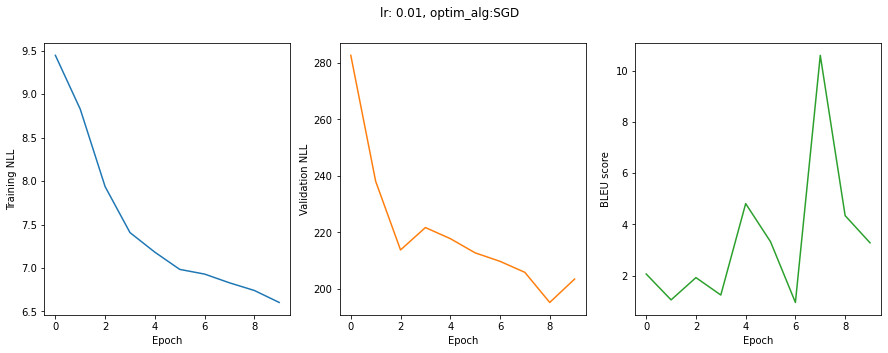

In [80]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(range(len(loss_list)), loss_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training NLL')
ax[1].plot(range(len(val_loss_list)), val_loss_list, color='tab:orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation NLL')
ax[2].plot(range(len(bleu_list)), bleu_list, color='tab:green')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('BLEU score')
plt.suptitle('lr: {}, optim_alg:{}'.format(0.01, 'SGD'))

Finally we print some translations.

In [81]:
trues, preds, test_loss_it_avg, test_loss_it, bleu_score = inference("test", test_loader, encoder_rnn, decoder_rnn, None, langorder, limit=1000)
print("======================================================================")
print("The BLUE score on the testing set is {}".format(bleu_score))
print("======================================================================")
print("A few example of translations on the testing set.")
print("----------------------------------------------------------------------")
for j in range(10):
  print(colored("Original sentence: ", 'cyan'), trues[j])
  print(colored("MT sentence: ", 'cyan'), preds[j])
  print("----------------------------------------------------------------------")

test:: 100%|██████████| 1000/1000 [00:46<00:00, 21.73it/s]


test : (loss 0.0) (blue BLEU = 0.74 15.8/0.5/0.3/0.1 (BP = 1.000 ratio = 1.011 hyp_len = 95 ref_len = 94))
The BLUE score on the testing set is BLEU = 0.74 15.8/0.5/0.3/0.1 (BP = 1.000 ratio = 1.011 hyp_len = 95 ref_len = 94)
A few example of translations on the testing set.
----------------------------------------------------------------------
Original sentence:  ['we hope that we can count on the support of parliament , and - why not say it - of the council to secure these resources and to achieve these objectives , so that the establishment of an area of freedom , security and justice becomes a reality as soon as possible , thus allowing us all to contribute , in a spirit of interinstitutional cooperation , to the realisation of this project , which is , without a doubt , the " jewel in the crown " of the treaty of amsterdam .']
MT sentence:  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the th

So our model only predicts the most common word in the English corpus, which is a very bad translation indeed...

## RNN model with a GRU layer
Here, we take the model from the TP, which slightly improves on the Vanilla RNN by replacing the simple one-layer RNN by a one-layer Gated Recurrent Unit.

In [82]:
# Encoder
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
      input = input.to(device)
      # apply the embedding layer
      embedded = self.embedding(input)
      # modify the output shape in order for it to work with a GRU (we use batches of one element)
      output = embedded.view(1, 1, -1)
      # apply the GRU layer
      output, hidden = self.gru(output, hidden)
      # return both the output, and the hidden vector
      return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Decoder
class DecoderGRU(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderGRU, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)
        # apply the embedding layer and modify the output shape in order for it to work with a GRU (we use batches of one element)
        output = self.embedding(input).view(1, 1, -1)
        # apply a ReLU non linearization layer
        output = F.relu(output)
        # apply the GRU layer
        output, hidden = self.gru(output, hidden)
        # apply a softmax to get probabilities, on the first element of the output vector (batch is equal to one)
        output = self.softmax(self.out(output[0]))
        # return both the output probabilities and the hidden vector
        return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

We train the model.

In [83]:
hidden_size = 256
langorder = ['French', 'English']
epochs = 10

# instanciate the encoder
encoder_gru = EncoderGRU(VOC[langorder[0]]['nbwords'], hidden_size).to(device)
# instanciate the decoder
decoder_gru = DecoderGRU(hidden_size, VOC[langorder[1]]['nbwords']).to(device)

# run the epochs
loss_list, val_loss_list, bleu_list = run_epochs(encoder_gru, decoder_gru, epochs, learning_rate=0.01, limit=200, langorder=langorder)

Epoch 0:: 100%|██████████| 200/200 [00:24<00:00,  8.13it/s]


Epoch 0 : Training : (loss 5.725400200368977) 


validation:: 100%|██████████| 200/200 [00:09<00:00, 20.76it/s]


validation : (loss 194.92335750579835) (blue BLEU = 14.99 100.0/36.4/5.0/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 12 ref_len = 12))


Epoch 1:: 100%|██████████| 200/200 [00:26<00:00,  7.51it/s]


Epoch 1 : Training : (loss 5.360408237735877) 


validation:: 100%|██████████| 200/200 [00:03<00:00, 51.17it/s]


validation : (loss 31.566477432250977) (blue BLEU = 35.36 100.0/75.0/16.7/12.5 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 2:: 100%|██████████| 200/200 [00:27<00:00,  7.23it/s]


Epoch 2 : Training : (loss 5.476077849929353) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 33.49it/s]


validation : (loss 83.43172837734222) (blue BLEU = 21.97 100.0/61.5/8.3/4.5 (BP = 1.000 ratio = 1.000 hyp_len = 14 ref_len = 14))


Epoch 3:: 100%|██████████| 200/200 [00:25<00:00,  7.72it/s]


Epoch 3 : Training : (loss 5.202177885728431) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 42.40it/s]


validation : (loss 50.249064507484434) (blue BLEU = 33.03 100.0/71.4/16.7/10.0 (BP = 1.000 ratio = 1.000 hyp_len = 8 ref_len = 8))


Epoch 4:: 100%|██████████| 200/200 [00:23<00:00,  8.37it/s]


Epoch 4 : Training : (loss 4.8859340311306205) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 33.76it/s]


validation : (loss 86.2512014389038) (blue BLEU = 19.54 100.0/38.5/8.3/4.5 (BP = 1.000 ratio = 1.000 hyp_len = 14 ref_len = 14))


Epoch 5:: 100%|██████████| 200/200 [00:26<00:00,  7.45it/s]


Epoch 5 : Training : (loss 5.031489551508057) 


validation:: 100%|██████████| 200/200 [00:06<00:00, 29.93it/s]


validation : (loss 105.08820390701294) (blue BLEU = 17.40 100.0/33.3/7.1/3.8 (BP = 1.000 ratio = 1.000 hyp_len = 16 ref_len = 16))


Epoch 6:: 100%|██████████| 200/200 [00:24<00:00,  8.18it/s]


Epoch 6 : Training : (loss 4.836354655668917) 


validation:: 100%|██████████| 200/200 [00:07<00:00, 26.36it/s]


validation : (loss 130.1293334388733) (blue BLEU = 11.47 84.0/20.8/4.3/2.3 (BP = 1.000 ratio = 1.000 hyp_len = 25 ref_len = 25))


Epoch 7:: 100%|██████████| 200/200 [00:23<00:00,  8.45it/s]


Epoch 7 : Training : (loss 4.8588493840992655) 


validation:: 100%|██████████| 200/200 [00:04<00:00, 49.33it/s]


validation : (loss 31.992883486747743) (blue BLEU = 53.73 100.0/100.0/33.3/25.0 (BP = 1.000 ratio = 1.000 hyp_len = 5 ref_len = 5))


Epoch 8:: 100%|██████████| 200/200 [00:24<00:00,  8.07it/s]


Epoch 8 : Training : (loss 4.7236318297116675) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 38.81it/s]


validation : (loss 61.03270515441895) (blue BLEU = 23.36 100.0/33.3/12.5/7.1 (BP = 1.000 ratio = 1.000 hyp_len = 10 ref_len = 10))


Epoch 9:: 100%|██████████| 200/200 [00:24<00:00,  8.19it/s]


Epoch 9 : Training : (loss 4.3775699756475905) 


validation:: 100%|██████████| 200/200 [00:05<00:00, 39.33it/s]

validation : (loss 52.360135655403134) (blue BLEU = 16.52 100.0/25.0/7.1/4.2 (BP = 1.000 ratio = 1.000 hyp_len = 9 ref_len = 9))


Text(0.5, 0.98, 'lr: 0.01, optim_alg:SGD')

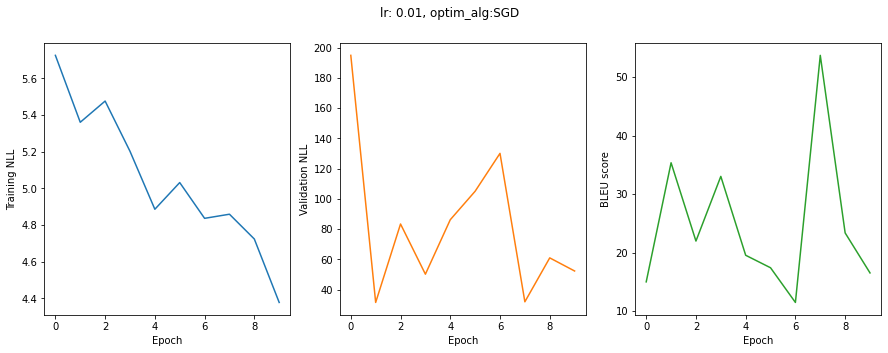

In [84]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(range(len(loss_list)), loss_list)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Training NLL')
ax[1].plot(range(len(val_loss_list)), val_loss_list, color='tab:orange')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Validation NLL')
ax[2].plot(range(len(bleu_list)), bleu_list, color='tab:green')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('BLEU score')
plt.suptitle('lr: {}, optim_alg:{}'.format(0.01, 'SGD'))

In [85]:
trues, preds, test_loss_it_avg, test_loss_it, bleu_score = inference("test", test_loader, encoder_rnn, decoder_rnn, None, langorder, limit=1000)
print("======================================================================")
print("The BLUE score on the testing set is {}".format(bleu_score))
print("======================================================================")
print("A few example of translations on the testing set.")
print("----------------------------------------------------------------------")
for j in range(10):
  print(colored("Original sentence: ", 'cyan'), trues[j])
  print(colored("MT sentence: ", 'cyan'), preds[j])
  print("----------------------------------------------------------------------")

test:: 100%|██████████| 1000/1000 [00:47<00:00, 20.89it/s]


test : (loss 0.0) (blue BLEU = 3.00 47.8/2.3/1.2/0.6 (BP = 1.000 ratio = 1.000 hyp_len = 23 ref_len = 23))
The BLUE score on the testing set is BLEU = 3.00 47.8/2.3/1.2/0.6 (BP = 1.000 ratio = 1.000 hyp_len = 23 ref_len = 23)
A few example of translations on the testing set.
----------------------------------------------------------------------
Original sentence:  ['the proposal already specifies that water must be abstracted in accordance with the ecological needs in the river basin district concerned .']
MT sentence:  the the the the the the the the the the the the the the the the the the the the the the the
----------------------------------------------------------------------
Original sentence:  ['clearly , parliament has its own representatives present , mr brok and mr tsatsos .']
MT sentence:  the the the the the the the the the the the the the the the the
----------------------------------------------------------------------
Original sentence:  ['let us all go back to our respec

This model is just like the last and predicts only the most common word in the corpus.

## Last data preparation for the Transformer models
Here we take into account the Word2Vec model to use with the Transformer models.

In [ ]:
EuroparlEnFr = Dataset.from_pandas(EuroparlEnFr_df[["English", "French"]])
EuroparlEnFr

Dataset({
    features: ['English', 'French'],
    num_rows: 20000
})

In [ ]:
#NEW_VOC={"English": {"word2index": wv_en_word2index, "index2word": wv_en.index2word}, "French": {"word2index":wv_fr_word2index, "index2word": wv_fr.index2word}}

# We here numericalize the entries of our dataset

def prepa(entry):
  """
  Processes the entry by numericalizing the two lists of tokens it contains
  """
  res={l:None for l in LANGS}
  for lang in LANGS:
    SOS_IDX = NEW_VOC[lang]["stoi"]['<sos>']
    EOS_IDX = NEW_VOC[lang]["stoi"]['<eos>']
    UNK_IDX = NEW_VOC[lang]["stoi"]['<unk>']
    tokens_entries = [ [SOS_IDX] + [ NEW_VOC[lang]["stoi"][t] if t in NEW_VOC[lang]["stoi"] else UNK_IDX for t in e ] + [EOS_IDX] for e in entry[lang]]
    res[lang] = tokens_entries
  return res
  
EuroparlEnFr = EuroparlEnFr.map(lambda e: prepa(e), batched=True)

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
EuroparlEnFr[0]

{'English': [7733, 3692, 3, 0, 1192, 7734],
 'French': [10238, 1354, 1, 3, 1006, 10239]}

In [ ]:
# We construct the lists determining the splitting of our data in train, test and validation samples
indices = [i for i in range(len(EuroparlEnFr))]
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

print(len(train_indices), len(val_indices), len(test_indices))

13400 3300 3300


In [ ]:
from torch.utils.data import Dataset

class EnfrDataset(Dataset):
  """
  The dataset class our model are able to handle, returning for each row a
  dictionnary {'English': [tokenized_sentence], 'French': [tokenized_sentence]}
  """
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = {
        "English": np.array(self.data[idx]['English']),
        "French": np.array(self.data[idx]['French'])
    }
    return item


In [ ]:
# We construct the 3 dataloaders
batchsize = 1
train_loader = DataLoader(EnfrDataset(EuroparlEnFr.select(train_indices)), batch_size=batchsize, shuffle=True, drop_last=True)
val_loader   = DataLoader(EnfrDataset(EuroparlEnFr.select(val_indices)),batch_size = batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(EnfrDataset(EuroparlEnFr.select(test_indices)),batch_size = batchsize, shuffle=True, drop_last=True)

In [ ]:
next(iter(train_loader))['English'].shape

torch.Size([1, 11])

In [ ]:
# Deletion of a few elements to free some space
del lines_fr, lines_en, tok_tweet, tok_tree, tok_tok, model_en, model_fr, wv_en, wv_fr, wv_en_word2index, wv_fr_word2index, Europarl_profile

## Machine translation with Transformer models

We now wish to explore the use of transformer models in Machine Translation tasks.

We first considered an un-trained model before exploring the use of the BART model.

### Learning the translation model from scratch

Here, we considered an encoder-decoder architecture with 6 stacked transformer layers in the encoder and decoder parts. Upstream of this model, we defined to embedding layers for both our languages using the Word2Vec embeddings. Then we added a language modeling head to compute the log-likelihood associated to each possible token.

In [ ]:
class TransformerEncoderDecoder(nn.Module):
  """
  Simple Tranformer encoder-decoder model with pretrained embeddings
  """
  def __init__(self, embed_vec_enc, embed_vec_dec):

    super().__init__()
    self.embd_enc = nn.Embedding.from_pretrained(embed_vec_enc, freeze=True)
    self.embd_dec = nn.Embedding.from_pretrained(embed_vec_dec, freeze=True)
    self.EncoderDecoder = nn.Transformer(d_model=embed_vec_enc.shape[1], nhead=5, batch_first=True)
    self.linear = nn.Linear(embed_vec_dec.shape[1], embed_vec_dec.shape[0])
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, inputs, outputs):

    inputs = self.embd_enc(inputs)
    outputs = self.embd_dec(outputs)
    h = self.EncoderDecoder(inputs, outputs)
    h = self.linear(h)
    h = self.softmax(h)
    
    return h


In [ ]:
def loss_fn(output, target, criterion):
  """
  Loss function
  Args:
    - output: a probability tensor of shape (N,S,V)
    - target: objective tensor of shape (N,S)
    - criterion: function to compute the loss per token
  """
  loss=0
  # we iterate over the sequence length, adding the loss associated to each token
  for k in range(min(target.shape[1], output.shape[1])):
    loss += criterion(output[:,k], target[:,k])
  return loss

In [ ]:
def Embed_to_word(x, inv_voc, is_BART_model, tokenizer):
  """
  Transforms numericalized entries in string sentences
  Args:
    - x: numericalised token tensor of shape (N,S)
    - inv_voc: the itos vocabulary giving the word corresponding to each index
    - is_BART_model: whether the numericalisation results from the BART tokenisation
    - tokenizer: the tokenizer corresponding to the BART model if any
  Returns a list of strings associated to the elements in x
  """
  out=[]
  if x is not None:
    for k in range(x.shape[0]):
      if is_BART_model: # for the BART model we can simply use the tokenizer
        out.append(tokenizer.decode(x[k]))
      else:
        out_temp=[]
        for j in range(x.shape[1]):
          emb=x[k,j].item()
          out_temp.append(inv_voc[emb])
        out_temp = ' '.join(out_temp)
        out.append(out_temp)
  return out

In [ ]:
# Choosing the device we are working on
device = 'cpu'
if torch.cuda.is_available():
  device = 'cuda'

def evaluate(val_loader, lang_in, lang_out, model, criterion, voc, loader_name="Validation", maxlen=maxlen, early_stop=False, is_BART_model=False, tokenizer=None):
  """
  Evaluates a model on a given loader, returning true and predicted sentences and losses and blue score
  Args:
    - val_loader: the loader contraining the data to evaluate on
    - lang_in: the language to translate from
    - lang_out: the language to translate to
    - model: the translation model
    - criterion: the criterion used to compute the loss
    - voc: the vocabulary of the two languages
    - loader_name: whether 'validation', 'test' or 'other' (for display purposes)
    - maxlen: the maximum length of the predicted translation
    - early_stop: True if only interested in the first 50 sentences
    - is_BART_model: whether the numericalisation results from the BART tokenisation
    - tokenizer: the tokenizer corresponding to the BART model if any
  """

  # Setting the model to eval mode (not activating the dropout layers, etc.)
  model.eval()

  it_loss=[]
  trues=[]
  preds=[]
  i=0

  for iter, inputs in tqdm(enumerate(val_loader), desc="%s:" % (loader_name), total=len(val_loader)):

    i+=1
    if early_stop & i>50:
      break
    
    with torch.no_grad():
      
      inputs_in, inputs_out = inputs[lang_in].to(device), inputs[lang_out]
      if inputs_out is not None:
        inputs_out = inputs_out.to(device)
      
      true = Embed_to_word(inputs_out, voc[lang_out]["itos"], is_BART_model, tokenizer)
      trues+=[[t] for t in true]

      # We initialise target with the <sos> token
      target = torch.tensor([[voc[lang_out]['stoi']["<sos>"]]])
      if inputs_out is None:
        max_dec = maxlen
      else:
        max_dec = inputs_out.shape[1]
      
      # We iterate over the maximum length of the prediction to gradually predict the translated sentence
      probs=torch.ones((inputs_in.shape[0], 1, len(voc[lang_out]['stoi']))).to(device)
      for j in range(max_dec):
        target = target.to(device)
        prob_tok = model(inputs_in, target)
        probs = torch.cat([probs, prob_tok], dim=1)
        next_tok = prob_tok.topk(1)[1].view(-1)[-1].item() # keep the token with the highest likelihood
        if next_tok==voc[lang_out]['stoi']['<eos>']: # if <eos> we stop the translation
          next_tok = torch.tensor([[next_tok]]).to(device)
          target = torch.cat([target, next_tok], dim=1)
          break
        else:
          next_tok = torch.tensor([[next_tok]]).to(device)
          target = torch.cat([target, next_tok], dim=1)
      
      probs = probs[:,1:] # drop the first line that corresponds to no token
      preds+= Embed_to_word(target, voc[lang_out]["itos"], is_BART_model, tokenizer)

      # If we have the true translation we can compute the loss
      if inputs_out is not None:
        loss = loss_fn(probs, inputs_out, criterion)
        it_loss.append(loss.item())
  
  # If we have the true translation we can compute the BLEU score and average score
  if inputs_out is not None:
    if len(preds)>0:
      bleu = BLEU()
      bleu_score = bleu.corpus_score(preds, trues)
    else:
      print("Error: no prediction constructed")
    
    avg_loss = sum(it_loss)/len(it_loss)
    
  else:
    avg_loss = None
    bleu_score = None
  
  # Print the validation loss and BLEU score
  print("%s : (%s %s) (%s %s)" % ( colored(loader_name, 'blue'), colored('loss', 'cyan'), avg_loss, colored('blue', 'cyan'), bleu_score ))

  return trues, preds, avg_loss, it_loss, bleu_score 

def sigmoid(x):
  return 1/(1+np.exp(-x))

def run_epochs(train_loader, val_loader, lang_in, lang_out, voc, model, learning_rate, nb_epochs, is_lr_scheduler=False, is_BART_model=False, tokenizer=None, weighted=False):
  """
  Runs multiple epochs on the model, printing progress and returning validation and training losses
  Args:
    - train_loader: the loader contraining the data to evaluate on
    - val_loader: the loader contraining the data to evaluate on
    - lang_in: the language to translate from
    - lang_out: the language to translate to
    - voc: the vocabulary of the two languages
    - model: the translation model
    - learning_rate: the learning rate for the optimizer
    - nb_epochs: the number of epochs (complete trainings over the entire training data)
    - is_lr_schedule: whether we want a learning rate scheduler during training
    - is_BART_model: whether the numericalisation results from the BART tokenisation
    - tokenizer: the tokenizer corresponding to the BART model if any
    - weighted: whether we consider a weighting of the tokens based on their occurence frequency in the loss
  """

  # Setting the model in train mode (activating dropout layers, etc.)
  model.train()

  # We set up the optimizer to train the learnable parameters
  optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = learning_rate)

  # If we want a learning rate scheduler (mostly when fine-tuning the BART model)
  if is_lr_scheduler:
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps = nb_epochs*len(train_loader))
  
  # If we want to give more weight to less frequent tokens during the loss computation
  # We chose the inverse token frequencies as the weights
  if weighted:
    nb_words = np.sum([voc[lang_out]['counts'][t] for t in voc[lang_out]['counts']])
    word_weights = [ nb_words/voc[lang_out]['counts'][t] if voc[lang_out]['counts'][t]!=0 else 0 for t in voc[lang_out]['counts'] ]
    #word_weights = [sigmoid(ww) for ww in word_weights]
    word_weights = torch.tensor(word_weights, dtype = torch.float32)
    word_weights.to(device)
  else:
    word_weights = None
  criterion = nn.NLLLoss(weight=word_weights)

  train_losses = []
  val_losses = []

  print("Start of the training ...")
  for epoch in range(nb_epochs):
    avg_loss = []
    for iter, inputs in tqdm(enumerate(train_loader), desc="Epoch %s:" % (epoch), total=len(train_loader)):

      inputs_in, inputs_out = inputs[lang_in].to(device), inputs[lang_out].to(device)

      optimizer.zero_grad()
      output = model(inputs_in, inputs_out)
      loss = loss_fn(output, inputs_out, criterion)
      loss.backward()
      optimizer.step()
      if is_lr_scheduler:
        lr_scheduler.step()
      
      avg_loss.append(loss.item())
    train_losses.append(sum(avg_loss)/len(avg_loss))

    # Print the average loss progression over epochs
    print("Epoch %s : %s : (%s %s) " % (colored(str(epoch), 'blue'), colored('Training', 'blue'), colored('loss', 'cyan'), train_losses[-1]))

    if epoch >= 20:
      # The validation step is very time consuming as it iterates over the length of the original sentence
      # To save some computation time, we do not compute the validation loss at each epoch, thus allowing for unmonitored over-fitting
      trues, preds, val_avg_loss, val_loss, bleu_score = evaluate(val_loader, lang_in, lang_out, model, criterion, voc, is_BART_model=is_BART_model, tokenizer=tokenizer)
      val_losses.append(val_avg_loss)
      model.train()

    # Save the model at each epoch to reload it in the following steps
    torch.save(model.state_dict(), 'ckpt.pth')

  return train_losses, val_losses


In [ ]:
# Defining the model and training it on our train loader
model = TransformerEncoderDecoder(torch.tensor(wv_fr_vectors), torch.tensor(wv_en_vectors))
model = model.float()
model.to(device)

train_losses, val_losses = run_epochs(train_loader, val_loader, 'French', 'English', NEW_VOC, model, 1e-4, 10, weighted=True)

Start of the training ...


Epoch 0:: 100%|██████████| 13400/13400 [41:42<00:00,  5.35it/s]


Epoch 0 : Training : (loss 21.658650585121016) 


Epoch 1:: 100%|██████████| 13400/13400 [43:34<00:00,  5.12it/s]


Epoch 1 : Training : (loss 10.974690988021564) 


Epoch 2:: 100%|██████████| 13400/13400 [44:57<00:00,  4.97it/s]


Epoch 2 : Training : (loss 9.386106742341159) 


Epoch 3:: 100%|██████████| 13400/13400 [47:53<00:00,  4.66it/s]


Epoch 3 : Training : (loss 8.899752038161688) 


Epoch 4:: 100%|██████████| 13400/13400 [47:08<00:00,  4.74it/s]


Epoch 4 : Training : (loss 8.726403884963343) 


Epoch 5:: 100%|██████████| 13400/13400 [46:27<00:00,  4.81it/s]


Epoch 5 : Training : (loss 8.65638835024411) 


Epoch 6:: 100%|██████████| 13400/13400 [52:18<00:00,  4.27it/s]


Epoch 6 : Training : (loss 8.621362642381186) 


Epoch 7:: 100%|██████████| 13400/13400 [49:52<00:00,  4.48it/s]


Epoch 7 : Training : (loss 8.603506068852191) 


Epoch 8:: 100%|██████████| 13400/13400 [49:09<00:00,  4.54it/s]


Epoch 8 : Training : (loss 8.588751480746057) 


Epoch 9:: 100%|██████████| 13400/13400 [50:21<00:00,  4.43it/s]


Epoch 9 : Training : (loss 8.578837601959817) 


In [ ]:
def plot_losses(train_losses, val_losses):
  """
  Plot the validation and training losses
  """
  plt.figure(figsize=(6,6))
  plt.title("Loss evolution through epochs")
  plt.plot(train_losses, color='orange')
  plt.plot(val_losses, color='blue')
  plt.xlabel("Epoch")
  plt.ylabel("Negative Log Likelihood Loss")
  plt.show()

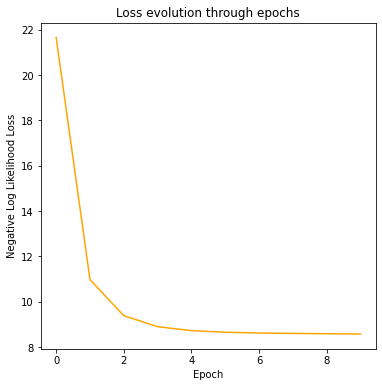

In [ ]:
# Plotting the training loss evolution over epochs
plot_losses(train_losses, val_losses)

In [ ]:
# We here evaluate our model on a subset of the training data
mini_loader = DataLoader(EnfrDataset(EuroparlEnFr.select(train_indices[0:50])), batch_size=batchsize, shuffle=True, drop_last=True)
# Evaluation on train set
ckpt = torch.load('ckpt.pth', map_location=device)
model.load_state_dict(ckpt)

criterion=nn.NLLLoss()
trues, preds, val_avg_loss, val_loss, bleu_score = evaluate(mini_loader, "French", "English", model, criterion, NEW_VOC, early_stop=True)
print("======================================================================")
print("The BLUE score on a subset of the training set is {}".format(bleu_score))
print("======================================================================")
print("A few example of translations on the training set.")
print("----------------------------------------------------------------------")
for j in range(10):
  print(colored("Original sentence: ", 'cyan'), trues[j])
  print(colored("MT sentence: ", 'cyan'), preds[j])
  print("----------------------------------------------------------------------")

Validation:: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]

Validation : (loss 49.85967551231384) (blue BLEU = 13.92 42.9/15.0/10.5/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 21 ref_len = 21))
The BLUE score on a subset of the training set is BLEU = 13.92 42.9/15.0/10.5/5.6 (BP = 1.000 ratio = 1.000 hyp_len = 21 ref_len = 21)
A few example of translations on the training set.
----------------------------------------------------------------------
Original sentence:  ['<sos> i should just like to point out once_again that the joint text still holds good . <eos>']
MT sentence:  <sos> the the the the the the table table table table table table stand likely once once once once
----------------------------------------------------------------------
Original sentence:  ['<sos> this is why we need to be sensible about applying quotas . <eos>']
MT sentence:  <sos> the the the the the the the table table table table table table stand
----------------------------------------------------------------------
Original sentence:  ['<sos> are you aware of this ? <eo

In [ ]:
# We here evaluate our model on a subset of the test data
mini_loader = DataLoader(EnfrDataset(EuroparlEnFr.select(test_indices[0:50])), batch_size=batchsize, shuffle=True, drop_last=True)
# Evaluation on test set
ckpt = torch.load('ckpt.pth', map_location=device)
model.load_state_dict(ckpt)

criterion=nn.NLLLoss()
trues, preds, val_avg_loss, val_loss, bleu_score = evaluate(mini_loader, "French", "English", model, criterion, NEW_VOC, early_stop=True)
print("======================================================================")
print("The BLUE score on a subset of the testing set is {}".format(bleu_score))
print("======================================================================")
print("A few example of translations on the testing set.")
print("----------------------------------------------------------------------")
for j in range(10):
  print(colored("Original sentence: ", 'cyan'), trues[j])
  print(colored("MT sentence: ", 'cyan'), preds[j])
  print("----------------------------------------------------------------------")

Validation:: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]

Validation : (loss 75.18644760131836) (blue BLEU = 6.55 24.4/6.8/4.7/2.4 (BP = 1.000 ratio = 1.000 hyp_len = 45 ref_len = 45))
The BLUE score on a subset of the testing set is BLEU = 6.55 24.4/6.8/4.7/2.4 (BP = 1.000 ratio = 1.000 hyp_len = 45 ref_len = 45)
A few example of translations on the testing set.
----------------------------------------------------------------------
Original sentence:  ['<sos> i do not wish to <unk> on this subject on behalf of the council presidency , because my government intervened at the request of , and in conjunction with , fourteen member states and not in its presidency capacity . <eos>']
MT sentence:  <sos> the the the the the the the table table table table table stand likely once once once once once once once once once once once once once once once once once indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed
----------------------------------------------------------------------
Original sentence:  ["<sos> mr van_hulten , m

In [ ]:
def translate(input_sentence, tokenizer, phraser, lang_in, lang_out, voc):
  """
  Translates a string sentence from lang_in to lang_out
  """
  input_sentence = tokenizer([input_sentence])[0]
  input_sentence = phraser[input_sentence]
  input_sentence = [voc[lang_in]['stoi']['<sos>']] + [voc[lang_in]['stoi'][w] if w in voc[lang_in]['stoi'] else voc[lang_in]['stoi']['<unk>'] for w in input_sentence] + [voc[lang_in]['stoi']['<eos>']]
  input_tensor = torch.tensor([input_sentence], dtype=torch.long)
  translation = evaluate([{lang_in: input_tensor, lang_out:None}], lang_in, lang_out, model, criterion, voc)[1]
  return translation

def translation_engine(tokenizer, phraser, lang_in, lang_out, voc):
  """
  Interactive translation engine
  """
  input_sentence = input("Do you have a sentence you wish to translate from French to English? \n If so please type it here or type 'exit' to exit: ")
  while input_sentence!="exit":
    translation = translate(input_sentence, tokenizer, phraser, lang_in, lang_out, voc)
    print(translation[0])
    input_sentence = input("Is there anything else you want to translate? ")

tok_tweet = TweetTokenizer()

In [ ]:
# Interactive on-demand translations
translation_engine(tokenizer, phraser_fr, "French", "English", NEW_VOC)

Do you have a sentence you wish to translate from French to English? 
 If so please type it here or type 'exit' to exit: How is that possible?


Validation:: 100%|██████████| 1/1 [00:16<00:00, 16.63s/it]


Validation : (loss None) (blue None)
<sos> the the the the the the the table table table table table table stand likely once once once once once once once once once once once once once once once once once indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed indeed furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore furthermore finally firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly firstly f

The translation model build in this section is evidently pretty bad. Increasing the number of sentences used for training, increasing the number of epochs and the complexity of the model are obvious avenues for improvement. The repercussion of such changes on the computation time and memory asset are however so drastic that we could not consider implementing them with the resources at hand.

### Finetuning of a pre-trained BART model

We now wanted to experiment with finetuning a pre-existing language modeling model to tailor it to our translation task.

We considered the BART model, an english language model. We kept the french corpus identical to the previous sections.

#### Preparing the English corpus with the BART procedure

First off, we needed to process the English corpus again to prepare it for the Bart model. We used the associated Bart tokenizer to process and tokenize our raw English text, keeping the French data as is.

In [ ]:
# Keep the same tokenisation for the French data
lines_fr = EuroparlEnFr_df['French']

# Consider the BART tokenisation for the English data
with open('europarl-v7.fr-en.en') as f:
  lines_en = f.readlines()
lines_en = lines_en[0:20000]

# Reconstruct the dataset
EuroparlEnFr_df_BART = pd.DataFrame({"English": lines_en, "French": lines_fr})
EuroparlEnFr_BART = datasets.Dataset.from_pandas(EuroparlEnFr_df_BART[["English", "French"]])
EuroparlEnFr_BART

# Import the BART tokenizer
tokenizer_en = AutoTokenizer.from_pretrained("facebook/bart-base")

# Prepare the entries with the new tokenization process for the english corpus
def prepa(entry):
  res={l:None for l in LANGS}

  # For the french text, we do the exact same processing
  lang="French"
  SOS_IDX = NEW_VOC[lang]["stoi"]['<sos>']
  EOS_IDX = NEW_VOC[lang]["stoi"]['<eos>']
  UNK_IDX = NEW_VOC[lang]["stoi"]['<unk>']
  tokens_entries = [ [SOS_IDX] + [ NEW_VOC[lang]["stoi"][t] if t in NEW_VOC[lang]["stoi"] else UNK_IDX for t in e ] + [EOS_IDX] for e in entry[lang]]
  res[lang] = tokens_entries

  # For the english text, we use the BART tokenizer
  lang="English"
  res[lang] = tokenizer_en(entry[lang], truncation=True)['input_ids']

  return res
  
EuroparlEnFr_BART = EuroparlEnFr_BART.map(lambda e: prepa(e), batched=True)

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
# Build the new dataloaders
batchsize=1

train_loader_BART = DataLoader(EnfrDataset(EuroparlEnFr_BART.select(train_indices)), batch_size=batchsize, shuffle=True, drop_last=True)
val_loader_BART = DataLoader(EnfrDataset(EuroparlEnFr_BART.select(val_indices)),batch_size = batchsize, shuffle=True, drop_last=True)
test_loader_BART = DataLoader(EnfrDataset(EuroparlEnFr_BART.select(test_indices)),batch_size = batchsize, shuffle=True, drop_last=True)

In [ ]:
next(iter(val_loader))

{'English': tensor([[7733,   58,  153,    9,   12,  135,    4,  999,   15,    1,    6,  677,
             4,  111,  143, 1975,    1,    7,    9,    3,  632, 1883,    6,   69,
             2, 7734]]),
 'French': tensor([[10238,     5,   154,   975,    19,   612,   115,  3128,     0,    11,
             31,     1,   224,   112, 10240,     0,    21,   372,     1,     3,
           1892,  1485,    11,   130,     2, 10239]])}

#### Adapting the BART model to the task at hand

As described in the original article [BART: Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation and Comprehension](https://arxiv.org/abs/1910.13461), we consider the BART model as the decoder block for our translation model. Instead of feeding to BART a tokenized english sentence, we gave it the result of the french embedded sentence encoding, bypassing the first embedding step of the model.

<br>

The authors mentionned that they obtained better results with this method, first fine-tuning only the added encoder part and then for a smaller number of epochs fine-tuning the entire model. Because of our limited resources, we have only carried out the first step, i.e. training the model and keeping the BART part constant. Performing the second step would certainly perfect our model.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

class BARTModel(nn.Module):
  """
  BART model adpated to our translation task by adding a transformer encoder upstream
  """
  def __init__(self, BART_model, embed_vec_enc):
    super().__init__()

    self.embd_enc = nn.Embedding.from_pretrained(embed_vec_enc, freeze=True)
    transformer_layers = nn.TransformerEncoderLayer(d_model=100, nhead=5, batch_first=True)
    self.encoder = nn.TransformerEncoder(transformer_layers, 2)
    # projection to go from W2V embedding dimension to BART embedding dimension
    self.projection = nn.Linear(100, 768) 
    self.decoder = BART_model
  
  def forward(self, inputs, outputs):

    h = self.embd_enc(inputs)
    h = self.encoder(h)
    h = self.projection(h)
    out = self.decoder(inputs_embeds=h, decoder_input_ids=outputs)

    return out.logits


In [ ]:
bart = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-base")
# We start out by freezing the BART model
for params in bart.parameters():
  params.requires_grad=False
# Now we append an encoder for the french text
model_bart = BARTModel(bart, torch.tensor(wv_fr_vectors))
model_bart = model_bart.float()
model_bart.to(device)

BARTModel(
  (embd_enc): Embedding(10241, 100)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
  

In [ ]:
train_losses, val_losses = run_epochs(train_loader_BART, val_loader_BART, 'French', 'English', NEW_VOC, model_bart, 1e-4, 5, is_lr_scheduler=True, is_BART_model=True, tokenizer=tokenizer_en)

Start of the training ...


Epoch 0:: 100%|██████████| 13400/13400 [3:15:51<00:00,  1.14it/s]


Epoch 0 : Training : (loss -420.5282386552042) 


Epoch 1:: 100%|█████████▉| 13342/13400 [3:06:37<00:34,  1.66it/s]

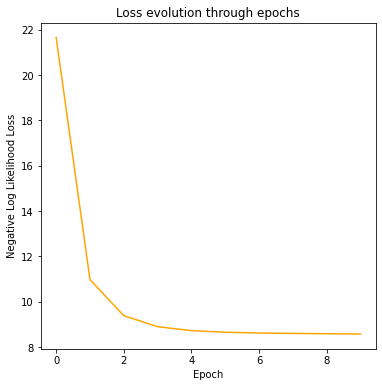

In [ ]:
plot_losses(train_losses, val_losses)

In [ ]:
mini_loader = DataLoader(EnfrDataset(EuroparlEnFr_BART.select(train_indices[0:50])), batch_size=batchsize, shuffle=True, drop_last=True)
# Evaluation on train set
ckpt = torch.load('ckpt.pth', map_location=device)
model_bart.load_state_dict(ckpt)

criterion=nn.NLLLoss()
trues, preds, val_avg_loss, val_loss, bleu_score = evaluate(mini_loader, "French", "English", model_bart, criterion, NEW_VOC, early_stop=True, is_BART_model=True, tokenizer=tokenizer_en)
print("======================================================================")
print("The BLUE score on a subset of the training set is {}".format(bleu_score))
print("======================================================================")
print("A few example of translations on the training set.")
print("----------------------------------------------------------------------")
for j in range(10):
  print(colored("Original sentence: ", 'cyan'), trues[j])
  print(colored("MT sentence: ", 'cyan'), preds[j])
  print("----------------------------------------------------------------------")

In [ ]:
mini_loader = DataLoader(EnfrDataset(EuroparlEnFr_BART.select(train_indices[0:50])), batch_size=batchsize, shuffle=True, drop_last=True)
# Evaluation on train set
ckpt = torch.load('ckpt.pth', map_location=device)
model_bart.load_state_dict(ckpt)

criterion=nn.NLLLoss()
trues, preds, val_avg_loss, val_loss, bleu_score = evaluate(mini_loader, "French", "English", model_bart, criterion, NEW_VOC, early_stop=True, is_BART_model=True, tokenizer=tokenizer_en)
print("======================================================================")
print("The BLUE score on a subset of the training set is {}".format(bleu_score))
print("======================================================================")
print("A few example of translations on the training set.")
print("----------------------------------------------------------------------")
for j in range(10):
  print(colored("Original sentence: ", 'cyan'), trues[j])
  print(colored("MT sentence: ", 'cyan'), preds[j])
  print("----------------------------------------------------------------------")